# 1D harmonic oscillator physics-informed neural network (PINN)

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~
$$


## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.set_default_device(device)

import numpy as np
import matplotlib.pyplot as plt

signorm = torch.nn.functional.sigmoid

# sine activation function class
class Sine(nn.Module):
    def __init__(self):
        super(Sine, self).__init__()

    def forward(self, x):
        return torch.sin(x)


# cosine activation function class
class Cosine(nn.Module):
    def __init__(self):
        super(Cosine, self).__init__()

    def forward(self, x):
        return torch.cos(x)

class Stan(nn.Module):
    """
    Self-scalable Tanh (Stan)
    References: Gnanasambandam, Raghav and Shen, Bo and Chung, Jihoon and Yue, Xubo and others.
    Self-scalable Tanh (Stan): Faster Convergence and Better Generalization
    in Physics-informed Neural Networks. arXiv preprint arXiv:2204.12589, 2022.
    """

    def __init__(self, out_features=1):
        super().__init__()
        self.beta = nn.Parameter(torch.ones(out_features))

    def forward(self, x):
        if x.shape[-1] != self.beta.shape[-1]:
            raise ValueError(
                f"The last dimension of the input must be equal to the dimension of Stan parameters. Got inputs: {x.shape}, params: {self.beta.shape}"
            )
        return torch.tanh(x) * (1.0 + self.beta * x)



# Define the neural network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # self.act = Cosine()
        # self.act = nn.GELU()
        # self.act = Stan(out_features=50)
        self.act = nn.Tanh()
        self.net = nn.Sequential(
            nn.Linear(1, 50),  # Input layer (time t)
            self.act,         # Activation function
            nn.Linear(50, 50), # Hidden layer
            self.act,         # Activation function
            nn.Linear(50, 1)   # Output layer (displacement x)
        )

    def forward(self, t):
        return self.net(t)

def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0

    w = torch.sqrt(w0**2-d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi+w*t)
    # sin = torch.sin(phi+w*t)
    exp = torch.exp(-d*t)
    x  = exp*2*A*cos
    return x


# Define the physics-informed loss
def physics_loss(model, mu, k):
    """Defines the physics-informed loss function for the 1D underdamped harmonic oscillator problem."""

    # # t0 is the initial time, tL is the final time, tn are the n time points in between
    t0 = torch.FloatTensor(1,1).fill_(0.0).requires_grad_(True)
    tn = torch.FloatTensor(29,1).uniform_(0, 1).requires_grad_(True)
    # tL = torch.FloatTensor(1).fill_(2.0).reshape(-1, 1).requires_grad_(True)
    t = torch.concat([t0, tn], dim=0)
    mask = t.squeeze()<=0.5


    # t = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

    
    
    # True displacement
    x_true = oscillator(d, w0, t).reshape(-1, 1)
    
    # Predict displacement
    x = model(t)
    
    # Data loss
    dloss = torch.mean((x-x_true)[mask]**2)

    # Automatically compute derivatives
    x_t = torch.autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]  # dx/dt
    x_tt = torch.autograd.grad(x_t, t, torch.ones_like(x_t), create_graph=True)[0]  # d^2x/dt^2
    
    # Compute the residual of the differential equation
    phy = x_tt + mu*x_t + k*x # = 0
    ploss = torch.mean(phy**2)

    ic1 = torch.mean((x[0]-1.)**2)
    ic2 = torch.mean((x_t[0]-0.)**2)
    ic = ic1 + ic2

    

    # Return the mean squared error against the expected zero
    return (ploss, # physics loss
            dloss, # data loss
            ic) # initial condition loss


# Initialize model, optimizer, and training parameters
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

d, w0 = 2, 20
mu, k = 2*d, w0**2


torch.Size([500, 1]) torch.Size([500, 1])


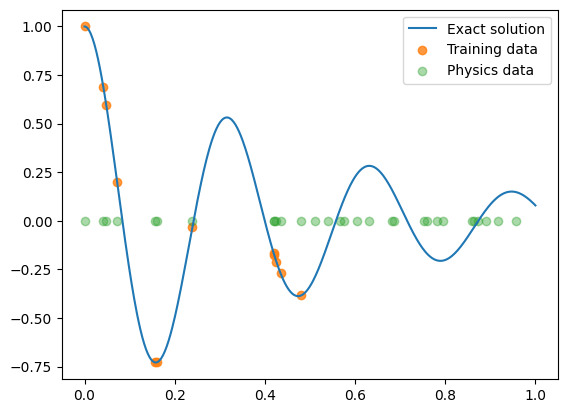

In [8]:
# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(torch.Tensor([d]), torch.Tensor([w0]), x).view(-1,1)
print(x.shape, y.shape)

# # slice out a small number of points from the LHS of the domain
# x_data = x[0:250:20].squeeze()
# y_data = y[0:250:20].squeeze()


# x_physics = torch.linspace(0,1,30).view(-1,1) # sample locations over the problem domain
# t0 is the initial time, tL is the final time, tn are the n time points in between
t0 = torch.FloatTensor(1).fill_(0.0).reshape(-1, 1)
tn = torch.FloatTensor(29, 1).uniform_(0, 1)
# tL = torch.FloatTensor(1).fill_(2.0).reshape(-1, 1)
x_physics = torch.concat([t0, tn]).squeeze()
y_physics = oscillator(torch.Tensor([d]), torch.Tensor([w0]), x_physics).squeeze()

mask = x_physics <= .5


plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_physics[mask], y_physics[mask], color="tab:orange", alpha=0.8, label="Training data")
plt.scatter(x_physics, 0*x_physics, color="tab:green", alpha=0.4, label="Physics data")
plt.legend()
plt.show()

In [9]:
d, w0 = torch.Tensor([d]), torch.Tensor([w0])
mu, k = torch.Tensor([mu]), torch.Tensor([k])

plosses = []
dlosses = []

# list to track moving average of loss
losses = []  # moving average of loss

# Training loop
for epoch in range(100000):
    optimizer.zero_grad()

    ploss, dloss, icloss = physics_loss(model, mu, k)
    ploss *= 1e-4
    # loss = ploss + dloss + icloss
    loss = dloss
    loss.backward()
    optimizer.step()

    # calculate moving average of loss
    if len(losses) < 100:
        losses.append(loss.item())
    else:
        losses.pop(0)
        losses.append(loss.item())
    
    # check if loss has converged
    std = np.std(losses)
    mean = np.mean(losses)
    if len(losses) == 100 and std < 5e-6 and epoch > 1000 and loss.item() < 1e-5:
        print(f'Converged at epoch {epoch}')
        break
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch},\
        Loss: {mean:.3e},\
        Physics Loss: {ploss.item():.3e},\
        Data Loss: {dloss.item():.3e},\
        IC Loss: {icloss.item():.3e},\
        Loss Std: {std:.3e}')
        scheduler.step()
    
    plosses.append(ploss.item())
    dlosses.append(dloss.item())

Epoch 0,        Loss: 2.949e-01,        Physics Loss: 2.478e-01,        Data Loss: 2.949e-01,        IC Loss: 1.170e+00,        Loss Std: 0.000e+00
Epoch 100,        Loss: 2.404e-01,        Physics Loss: 2.687e+00,        Data Loss: 2.626e-01,        IC Loss: 1.683e+00,        Loss Std: 5.859e-02
Epoch 200,        Loss: 2.364e-01,        Physics Loss: 2.461e+00,        Data Loss: 2.128e-01,        IC Loss: 1.826e+00,        Loss Std: 5.314e-02
Epoch 300,        Loss: 2.467e-01,        Physics Loss: 2.390e+00,        Data Loss: 3.068e-01,        IC Loss: 1.714e+00,        Loss Std: 5.853e-02
Epoch 400,        Loss: 2.352e-01,        Physics Loss: 2.688e+00,        Data Loss: 3.342e-01,        IC Loss: 2.024e+00,        Loss Std: 6.447e-02
Epoch 500,        Loss: 2.346e-01,        Physics Loss: 2.132e+00,        Data Loss: 2.067e-01,        IC Loss: 1.902e+00,        Loss Std: 5.738e-02
Epoch 600,        Loss: 2.371e-01,        Physics Loss: 1.747e+00,        Data Loss: 2.423e-01,       

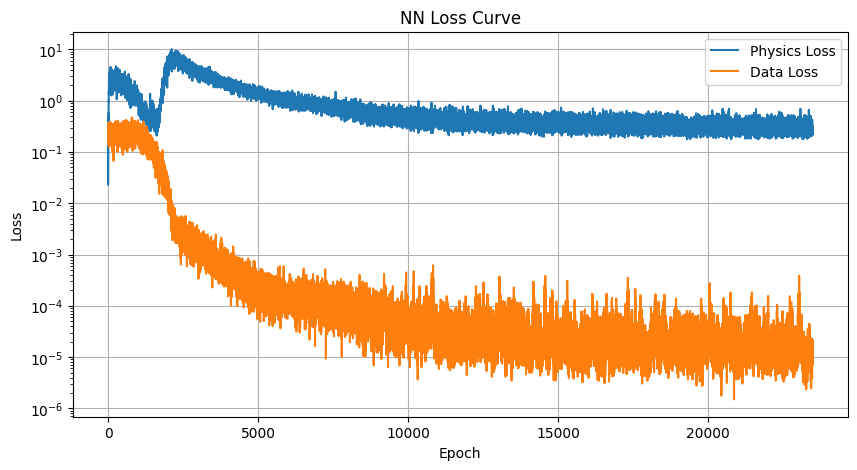

In [10]:
# plot log loss curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(plosses, label='Physics Loss')
ax.plot(dlosses, label='Data Loss')

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('NN Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


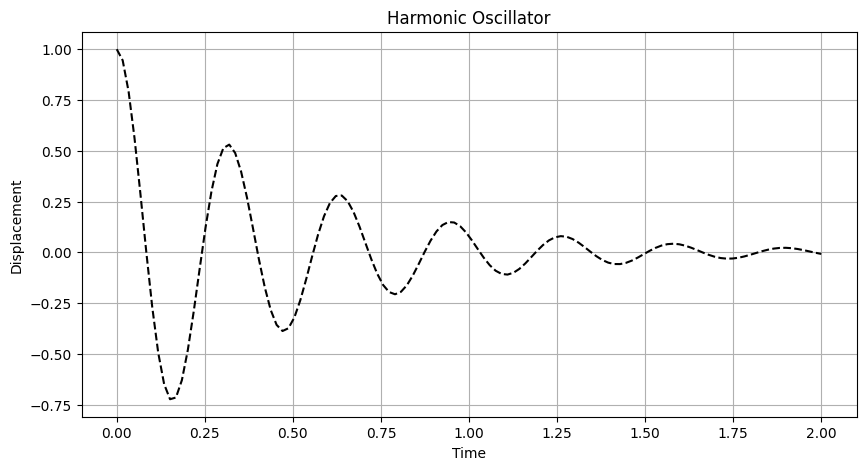

In [13]:
#plot predicted vs true displacement
model.eval()
td = torch.linspace(0, 2, 120).reshape(-1, 1).requires_grad_(True)
t0 = torch.FloatTensor(1).fill_(0.0).reshape(-1, 1)
tn = torch.FloatTensor(119, 1).uniform_(0, 2)
# tL = torch.FloatTensor(1).fill_(2.0).reshape(-1, 1)
tp = torch.concat([t0, tn])
x = model(td).squeeze().detach().numpy()
x_true = oscillator(d, w0, td).squeeze().detach().numpy()

td = td.squeeze().detach().numpy()
data_domain_mask = td<=0.5
physics_domain_mask = tp<=1.0



fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(td, x, color="red", label='Predicted')
ax.plot(td, x_true, color="black", linestyle='--', label='True')
# plt.scatter(td[data_domain_mask], x_true[data_domain_mask], color="tab:blue", alpha=0.8, label="Training data")
# plt.scatter(tp[physics_domain_mask], 0*tp[physics_domain_mask], color="tab:green", alpha=0.8, label="Physics domain")
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('Harmonic Oscillator')
# plt.legend()
plt.grid(True)
plt.show()




In [ ]:
#plot predicted vs true velocity
x_t = torch.autograd.grad(x,t, torch.ones_like(x), create_graph=True)[0]  # dx/dt
x_t_true = torch.autograd.grad(x_true,t, torch.ones_like(x_true), create_graph=True)[0]  # dx/dt

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t.detach().numpy(), x_t.detach().numpy(), label='Predicted')
ax.plot(t.detach().numpy(), x_t_true.detach().numpy(), label='True')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('PINN Predicted vs True Velocity')
plt.legend()
plt.grid(True)

plt.show()

#plot predicted vs true acceleration
x_tt = torch.autograd.grad(x_t,t, torch.ones_like(x_t), create_graph=True)[0]  # d^2x/dt^2
x_tt_true = torch.autograd.grad(x_t_true,t, torch.ones_like(x_t_true), create_graph=True)[0]  # d^2x/dt^2

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t.detach().numpy(), x_tt.detach().numpy(), label='Predicted')
ax.plot(t.detach().numpy(), x_tt_true.detach().numpy(), label='True')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('PINN Predicted vs True Acceleration')
plt.legend()
plt.grid(True)

plt.show()


# KAN PINN

In [3]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.set_default_device(device)

import numpy as np
import matplotlib.pyplot as plt

# sine activation function class
class Sine(nn.Module):
    def __init__(self):
        super(Sine, self).__init__()

    def forward(self, x):
        return torch.sin(x)


# cosine activation function class
class Cosine(nn.Module):
    def __init__(self):
        super(Cosine, self).__init__()

    def forward(self, x):
        return torch.cos(x)


# Define the neural network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = KAN(
            layers_hidden=[1, 50, 50, 1],  # Define the layer sizes
            grid_size=100,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.SiLU,
            grid_eps=0.02,
            grid_range=[-1, 1]
        )

    def forward(self, t):
        return self.net(t)


def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0

    w = torch.sqrt(w0**2-d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    x  = exp*2*A*cos
    return x


# Define the physics-informed loss
def physics_loss(model, mu, k):
    """Defines the physics-informed loss function for the 1D underdamped harmonic oscillator problem."""

    # t0 is the initial time, tL is the final time, tn are the n time points in between
    t0 = torch.FloatTensor(1,1).fill_(0.0).requires_grad_(True)
    tn = torch.FloatTensor(128,1).uniform_(0, 2).requires_grad_(True)
    # tL = torch.FloatTensor(1,1).fill_(2.0).requires_grad_(True)
    t = torch.concat([t0, tn], dim=0)
    mask = t.squeeze()<=0.5

    # True displacement
    x_true = oscillator(d, w0, t).reshape(-1, 1)
    
    # Predict displacement
    x = model(t)
    
    # Data loss
    dloss = torch.mean((x-x_true)[mask]**2)

    # Automatically compute derivatives
    x_t = torch.autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]  # dx/dt
    x_tt = torch.autograd.grad(x_t, t, torch.ones_like(x_t), create_graph=True)[0]  # d^2x/dt^2
    
    # Compute the residual of the differential equation
    phy = x_tt + mu*x_t + k*x # = 0
    ploss = torch.mean(phy**2)

    ic1 = torch.mean((x[0]-1.)**2)
    ic2 = torch.mean((x_t[0]-0.)**2)
    ic = ic1 + ic2

    # Return the mean squared error against the expected zero
    return (ploss, # physics loss
            dloss, # data loss
            ic) # initial condition loss


# Initialize model, optimizer, and training parameters
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

d, w0 = 2, 40
mu, k = 2*d, w0**2

d, w0 = torch.Tensor([d]), torch.Tensor([w0])
mu, k = torch.Tensor([mu]), torch.Tensor([k])

plosses = []
dlosses = []

# list to track moving average of loss
losses = []  # moving average of loss

# Training loop
for epoch in range(100000):
    optimizer.zero_grad()

    ploss, dloss, icloss = physics_loss(model, mu, k)
    ploss *= 1e-4
    loss = ploss + dloss + icloss
    # loss = dloss
    loss.backward()
    optimizer.step()

    # calculate moving average of loss
    if len(losses) < 100:
        losses.append(loss.item())
    else:
        losses.pop(0)
        losses.append(loss.item())
    
    # check if loss has converged
    std = np.std(losses)
    mean = np.mean(losses)
    if len(losses) == 100 and std < 5e-6 and epoch > 1000 and loss.item() < 1e-5:
        print(f'Converged at epoch {epoch}')
        break
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch},\
        Loss: {mean:.3e},\
        Physics Loss: {ploss.item():.3e},\
        Data Loss: {dloss.item():.3e},\
        IC Loss: {icloss.item():.3e},\
        Loss Std: {std:.3e}')
        scheduler.step()
    
    plosses.append(ploss.item())
    dlosses.append(dloss.item())


Epoch 0,        Loss: 2.044e+00,        Physics Loss: 7.255e-01,        Data Loss: 3.174e-01,        IC Loss: 1.001e+00,        Loss Std: 0.000e+00
Epoch 100,        Loss: 8.273e-01,        Physics Loss: 1.761e-01,        Data Loss: 8.713e-02,        IC Loss: 2.714e-01,        Loss Std: 2.624e-01
Epoch 200,        Loss: 3.075e-01,        Physics Loss: 1.065e-01,        Data Loss: 2.188e-02,        IC Loss: 4.272e-02,        Loss Std: 1.188e-01
Epoch 300,        Loss: 1.075e-01,        Physics Loss: 3.366e-02,        Data Loss: 4.321e-03,        IC Loss: 8.802e-03,        Loss Std: 4.326e-02
Epoch 400,        Loss: 4.317e-02,        Physics Loss: 2.281e-02,        Data Loss: 8.758e-04,        IC Loss: 5.413e-03,        Loss Std: 1.846e-02
Epoch 500,        Loss: 2.678e-02,        Physics Loss: 2.457e-02,        Data Loss: 1.664e-04,        IC Loss: 8.159e-04,        Loss Std: 1.082e-02
Epoch 600,        Loss: 9.876e-03,        Physics Loss: 5.466e-03,        Data Loss: 4.194e-05,       

KeyboardInterrupt: 

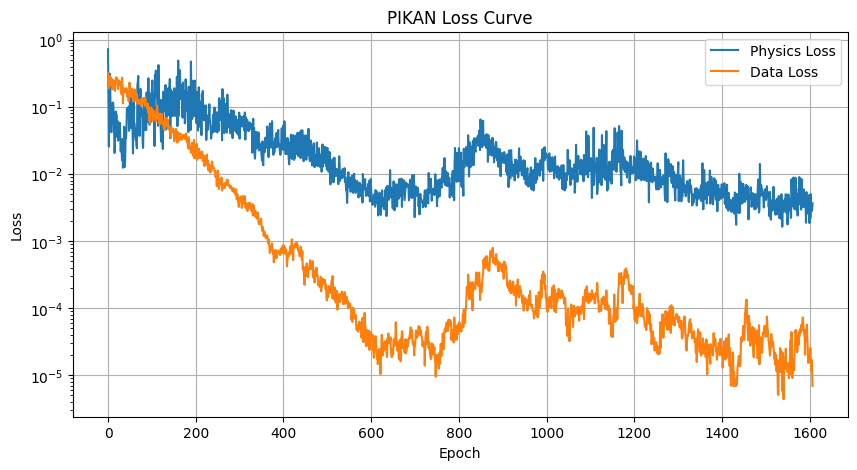

In [45]:
# plot log loss curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(plosses, label='Physics Loss')
ax.plot(dlosses, label='Data Loss')

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PIKAN Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


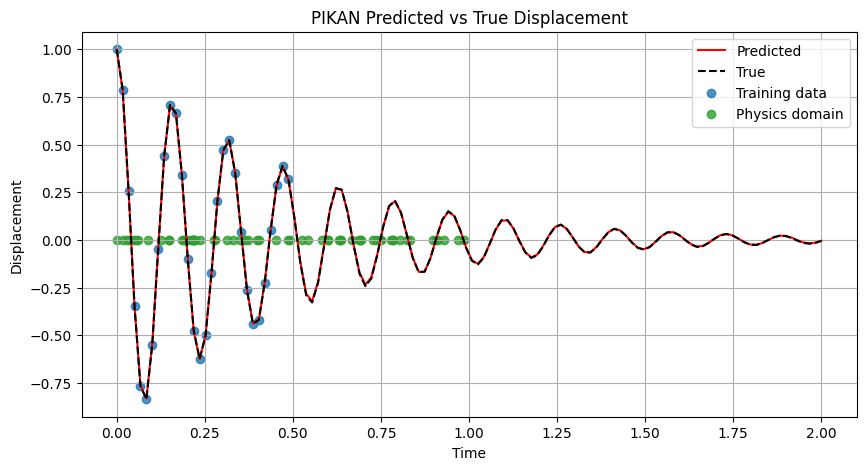

In [46]:
#plot predicted vs true displacement
model.eval()
td = torch.linspace(0, 2, 120).reshape(-1, 1).requires_grad_(True)
t0 = torch.FloatTensor(1).fill_(0.0).reshape(-1, 1)
tn = torch.FloatTensor(119, 1).uniform_(0, 2)
# tL = torch.FloatTensor(1).fill_(2.0).reshape(-1, 1)
tp = torch.concat([t0, tn])
x = model(td).squeeze().detach().numpy()
x_true = oscillator(d, w0, td).squeeze().detach().numpy()

td = td.squeeze().detach().numpy()
data_domain_mask = td<=0.5
physics_domain_mask = tp<=1.0



fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(td, x, color="red", label='Predicted')
ax.plot(td, x_true, color="black", linestyle='--', label='True')
plt.scatter(td[data_domain_mask], x_true[data_domain_mask], color="tab:blue", alpha=0.8, label="Training data")
plt.scatter(tp[physics_domain_mask], 0*tp[physics_domain_mask], color="tab:green", alpha=0.8, label="Physics domain")
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('PIKAN Predicted vs True Displacement')
plt.legend()
plt.grid(True)
plt.show()




# Forecast

Epoch [100/1000], Loss: 0.3725
Epoch [200/1000], Loss: 0.0003
Epoch [300/1000], Loss: 0.0001
Epoch [400/1000], Loss: 0.0001
Epoch [500/1000], Loss: 0.0001
Epoch [600/1000], Loss: 0.0001
Epoch [700/1000], Loss: 0.0001
Epoch [800/1000], Loss: 0.0001
Epoch [900/1000], Loss: 0.0001
Epoch [1000/1000], Loss: 0.0001


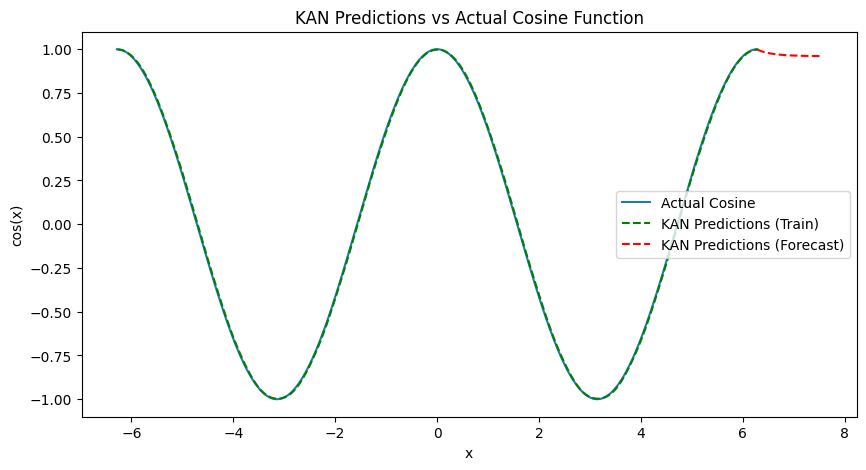

In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generate the data
x = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
y = np.cos(x)
x_train = y[:-1].reshape(-1, 1)
y_train = y[1:].reshape(-1, 1)

# Convert data to PyTorch tensors
x_tensor = torch.from_numpy(x_train).float()
y_tensor = torch.from_numpy(y_train).float()

# Initialize the model, loss function, and optimizer
model = KAN(
    layers_hidden=[1, 50, 50, 1],  # Define the layer sizes
    grid_size=5,
    spline_order=3,
    scale_noise=0.1,
    scale_base=1.0,
    scale_spline=1.0,
    base_activation=Cosine,
    grid_eps=0.02,
    grid_range=[-1, 1]
        )
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Make predictions
model.eval()
with torch.no_grad():
    future_x = x_tensor[-1].reshape(1, 1)
    future_predictions = []
    for _ in range(100):
        future_pred = model(future_x)
        future_predictions.append(future_pred.item())
        future_x = future_pred.reshape(1, 1)

# Prepare data for plotting
train_predictions = model(x_tensor).detach().numpy()
future_x_plot = np.linspace(x[-1], x[-1] + 100 * (x[1] - x[0]), 100)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Actual Cosine')
plt.plot(x[1:], train_predictions, 'g--', label='KAN Predictions (Train)')
plt.plot(future_x_plot, future_predictions, 'r--', label='KAN Predictions (Forecast)')
plt.legend()
plt.xlabel('x')
plt.ylabel('cos(x)')
plt.title('KAN Predictions vs Actual Cosine Function')
plt.show()
